# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).




In [2]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# tf и huggingface 
import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [5]:
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)

Mounted at /content/drive


In [4]:
data = pd.read_csv('drive/MyDrive/CL_hw/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

### distilbert-base-multilingual-cased

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_distilbert = TFAutoModel.from_pretrained('distilbert-base-multilingual-cased')

In [ ]:
X = []
for text in data.title:
    ids = tokenizer.encode(text)
    X.append(ids[:512])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {label: i for i, label in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name='input_ids')

output = model_distilbert({'input_ids': input_word_ids})

drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_distilbert_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

model_distilbert_clf.compile(tf.optimizers.Adam(learning_rate=2e-3), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_distilbert_clf.fit(X_train, y_train, 
            validation_data=(X_valid, y_valid),
            batch_size=20,
            epochs=20)

Epoch 1/20
29/29 [==============================] - 1695s 58s/step - loss: 4.3671 - accuracy: 0.0573 - rec_prec: 0.0000e+00 - val_loss: 3.1728 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 1657s 57s/step - loss: 3.0291 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.8738 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 1664s 57s/step - loss: 2.9468 - accuracy: 0.0694 - rec_prec: 0.0017 - val_loss: 2.8539 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 1690s 58s/step - loss: 2.9950 - accuracy: 0.0590 - rec_prec: 0.0017 - val_loss: 2.9832 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 1766s 61s/step - loss: 2.9508 - accuracy: 0.0799 - rec_prec: 0.0000e+00 - val_loss: 2.8088 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 [=========================

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


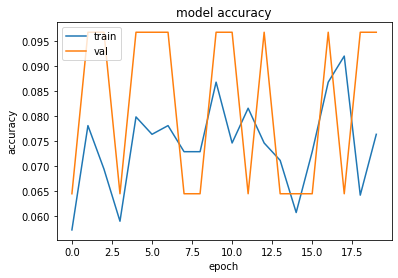

In [ ]:
print(model_distilbert_clf.history.history.keys())
plt.plot(model_distilbert_clf.history.history['accuracy'])
plt.plot(model_distilbert_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_distilbert_clf.predict(X_valid, batch_size=5).argmax(1)

In [ ]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

Силовые структуры       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
         Из жизни       0.00      0.00      0.00         3
   Интернет и СМИ       0.00      0.00      0.00         2
      Бывший СССР       0.00      0.00      0.00         3
             Крым       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
              Дом       0.00      0.00      0.00         2
         Культура       0.10      1.00      0.18         3
        Экономика       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
            Спорт       0.00      0.00      0.00         2
         Ценности       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
       Библиотека       0.00      0.00      0.00         0
  Наука и техника       0.00      0.00      0.00       

### Skoltech/russian-sensitive-topics

In [8]:
X = []
for text in data.title:
    ids = tokenizer.encode(text)
    X.append(ids[:512])

In [9]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [10]:
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {label: i for i, label in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [11]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [12]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [13]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name='input_ids')

output = model_sensit({'input_ids': input_word_ids})

drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_sensit_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

model_sensit_clf.compile(tf.optimizers.Adam(learning_rate=2e-3), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [14]:
model_sensit_clf.fit(X_train, y_train, 
            validation_data=(X_valid, y_valid),
            batch_size=20,
            epochs=20)

Epoch 1/20
29/29 [==============================] - 42s 1s/step - loss: 3.1053 - accuracy: 0.0729 - rec_prec: 0.0000e+00 - val_loss: 2.8429 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 27s 929ms/step - loss: 2.9957 - accuracy: 0.0868 - rec_prec: 0.0000e+00 - val_loss: 2.8801 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 28s 952ms/step - loss: 2.9388 - accuracy: 0.0694 - rec_prec: 0.0000e+00 - val_loss: 2.8026 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 28s 978ms/step - loss: 2.9174 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.8453 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 29s 985ms/step - loss: 2.9276 - accuracy: 0.0747 - rec_prec: 0.0035 - val_loss: 2.8214 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 [========================

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


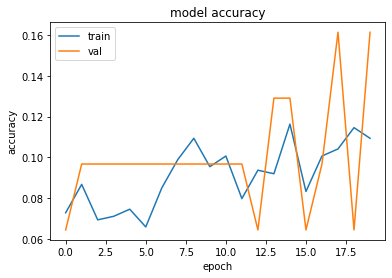

In [15]:
print(model_sensit_clf.history.history.keys())
plt.plot(model_sensit_clf.history.history['accuracy'])
plt.plot(model_sensit_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
pred = model_sensit_clf.predict(X_valid, batch_size=10).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Ценности       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
         Из жизни       0.29      0.67      0.40         3
              Дом       1.00      0.50      0.67         2
           Россия       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
         Культура       0.00      0.00      0.00         3
            Спорт       0.00      0.00      0.00         2
      Бывший СССР       0.09      0.67      0.16         3
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
   69-я параллель       0.00      0.00      0.00         1
           Бизнес       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
   Интернет и СМИ       0.00      0.00      0.00       

### roberta-base

In [ ]:
tokenizer_roberta = AutoTokenizer.from_pretrained('roberta-base')
model_roberta = TFAutoModel.from_pretrained('roberta-base', trainable=True)

In [45]:
X = []

for text in data.title:
    ids = tokenizer_roberta.encode(text)
    
    X.append(ids[:512])

In [46]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [47]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [48]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [49]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [50]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_roberta({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_roberta_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_roberta_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [51]:
model_roberta_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)

Epoch 1/20
288/288 [==============================] - 94s 295ms/step - loss: 2.9944 - accuracy: 0.0503 - rec_prec: 0.0000e+00 - val_loss: 2.7202 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 82s 286ms/step - loss: 2.8354 - accuracy: 0.0694 - rec_prec: 0.0000e+00 - val_loss: 2.7183 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 82s 286ms/step - loss: 2.8555 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.7100 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 83s 287ms/step - loss: 2.8416 - accuracy: 0.0833 - rec_prec: 0.0000e+00 - val_loss: 2.7218 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 82s 286ms/step - loss: 2.8462 - accuracy: 0.0608 - rec_prec: 0.0000e+00 - val_loss: 2.7088 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
288/288 [=====

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


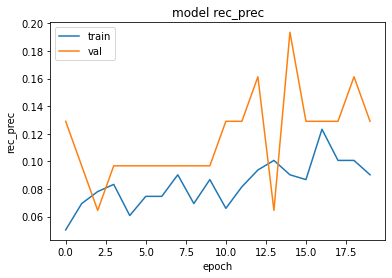

In [52]:
print(model_roberta_clf.history.history.keys())
plt.plot(model_roberta_clf.history.history['accuracy'])
plt.plot(model_roberta_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
pred = model_roberta_clf.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Ценности       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
         Из жизни       0.00      0.00      0.00         3
              Дом       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
Силовые структуры       0.11      1.00      0.20         2
             Крым       0.00      0.00      0.00         0
         Культура       0.00      0.00      0.00         3
            Спорт       0.00      0.00      0.00         2
      Бывший СССР       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
   69-я параллель       0.00      0.00      0.00         1
           Бизнес       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
   Интернет и СМИ       0.00      0.00      0.00       

__Лучше всего себя показала модель Skoltech/russian-sensitive-topics с f1-score 0.10, далее идёт модель roberta-base с 0.04, и затем - distilbert-base-multilingual-cased с 0.02.__

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

__Ответ:__ ROBERTA описана в статье 'RoBERTa: A Robustly Optimized BERT Pretraining Approach' (Liu, Yinhan, et al., 2019). 
Отличия ROBERTA от BERT: 
1. ROBERTA использует динамическое маскирование (помогает лучшить производительность), а BERT - статичное.
2. У ROBERTA byte-level BPE при токенизации (используются байты, а не Unicode символы), а у BERT character-level BPE. 
3. Обучение ROBERTA длилось дольше и на б_о_льшем количестве данных (BERT: 16 GB (Book Corpus + Wikipedia) против ROBERTA: 160 GB (16GB BERT data + 144GB aдополнительных как CCNews, OpenWebText, Stories)) и размер батча был больше.
4. При обучении ROBERTA убрали задачу предсказания следующего предложения 

2) Чем модель T5 отличается от ROBERTA/BERT? 

Отличие T5 от BERT/ROBERTA в том, что в T5 вход и выход представлены текстом (text-to-text format), что позволяет использовать её в б_о_льшем количестве задач. BERT/ROBERTA же на выход подают либо метку класса, либо фрагмент входных данных.